In [2]:
import os
import zipfile
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import re
  
# Initialize a list to store file details  
file_details = []  
processed_dir = '../data/NFBS_Dataset_Flat'  
  
# Define a regex pattern to extract key parts of the filename  
# Assuming filenames like sub-A00028185_ses-NFB3_T1w.nii, sub-A00028185_ses-NFB3_T1w_brain.nii, sub-A00028185_ses-NFB3_T1w_brainmask.nii  
pattern = re.compile(  
    r"sub-(?P<SubjectID>A\d+)_ses-(?P<SessionID>\w+)_T1w(_(?P<ScanDetail>.+))?\.nii"  
)  
  
# Loop through the directory and collect file details  
for root, dirs, files in os.walk(processed_dir):  
    for file_name in files:  
        if file_name.endswith('.nii'):  # Check if it's an .nii file  
            match = pattern.match(file_name)  
            if match:  
                subject_id = match.group('SubjectID')  
                session_id = match.group('SessionID')  
                scan_detail = match.group('ScanDetail') if match.group('ScanDetail') else 'T1w'  
  
                normalized_file_path = os.path.join(root, file_name).replace('\\', '/')  
  
                file_details.append({  
                    'Subject ID': subject_id,  
                    'Session ID': session_id,  
                    'Scan Detail': scan_detail,  
                    'File Path': normalized_file_path  
                })  
            else:  
                print(f"File does not match expected structure: {file_name}")  
  
# Convert the list to a DataFrame  
summary_df = pd.DataFrame(file_details)  
  
filtered_df = summary_df[summary_df['Scan Detail'] == 'brain']  
  
# Delete files where Scan Detail is not 'brain'  
for index, row in summary_df.iterrows():  
    if row['Scan Detail'] != 'brain':  
        os.remove(row['File Path'])  
  
# If there are any 'brain' files, get the first one  
if not filtered_df.empty:  
    first_nii_file = filtered_df['File Path'].iloc[0]  
    print(f"First .nii file with Scan Detail 'brain': {first_nii_file}")  
else:  
    print("No .nii file with Scan Detail 'brain' found.")  
  
# Save or display the summary of remaining files  
summary_file = '../data/NFBS_detailed_summary.csv'  
filtered_df.to_csv(summary_file, index=False)  
print(f"Detailed summary created: {summary_file}") 

First .nii file with Scan Detail 'brain': ../data/NFBS_Dataset_Flat/sub-A00028185_ses-NFB3_T1w_brain.nii
Detailed summary created: ../data/NFBS_detailed_summary.csv


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import logging
import wandb
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import os
import numpy as np
import nibabel as nib
import pandas as pd
from torch import Tensor
import torchvision.transforms.functional as TF
from scipy.special import erf
import random

# Image Processing Function
def Img_proc(image, _lambda=-0.8, epsilon=1e-6):
    I_img = image
    I_img_norm = (I_img - np.min(I_img)) / (np.max(I_img) - np.min(I_img) + epsilon)

    # Step 1: Compute IMG1
    max_I_img = np.max(I_img_norm)
    IMG1 = (max_I_img / np.log(max_I_img + 1 + epsilon)) * np.log(I_img_norm + 1)

    # Step 2: Compute IMG2
    IMG2 = 1 - np.exp(-I_img_norm)

    # Step 3: Compute IMG3
    IMG3 = (IMG1 + IMG2) / (_lambda + (IMG1 * IMG2))

    # Step 4: Compute IMG4
    IMG4 = erf(_lambda * np.arctan(np.exp(IMG3)) - 0.5 * IMG3)

    # Step 5: Compute IMG5 (Normalization)
    min_IMG4 = np.min(IMG4)
    max_IMG4 = np.max(IMG4)
    IMG5 = (IMG4 - min_IMG4) / (max_IMG4 - min_IMG4 + epsilon)

    return IMG5

# Enhanced Mask Generation Function
def generate_mask(image_shape, **kwargs):
    """
    Generates a mask based on the specified type.

    Args:
        image_shape (tuple): Shape of the image tensor (C, H, W).
        **kwargs: Additional parameters for mask generation.

    Returns:
        torch.Tensor: Mask tensor with the same spatial dimensions as the image.
    """
    C, H, W = image_shape
    mask = torch.ones((1, H, W), dtype=torch.float32)
    
    # Randomly choose mask type
    mask_type = random.choice(['random_square', 'circle', 'center_square'])

    if mask_type == 'random_square':
        # Example: Random square mask
        mask_size = kwargs.get('mask_size', 64)
        if H - mask_size > 0 and W - mask_size > 0:
            x = random.randint(0, H - mask_size)
            y = random.randint(0, W - mask_size)
            mask[:, x:x + mask_size, y:y + mask_size] = 0
        else:
            print("Mask size too large for the image dimensions. Skipping mask.")

    elif mask_type == 'center_square':
        # Example: Center square mask
        mask_size = kwargs.get('mask_size', 64)
        if mask_size < H and mask_size < W:
            x = (H - mask_size) // 2
            y = (W - mask_size) // 2
            mask[:, x:x + mask_size, y:y + mask_size] = 0
        else:
            print("Mask size too large for the image dimensions. Skipping mask.")

    elif mask_type == 'circle':
        # Example: Circular mask
        radius = kwargs.get('radius', min(H, W) // 8)
        center_x = H // 2
        center_y = W // 2
        Y, X = torch.meshgrid(torch.arange(H), torch.arange(W))
        dist = (X - center_y) ** 2 + (Y - center_x) ** 2
        mask[0, :, :] = (dist > radius ** 2).float()

    # Add more mask types as needed

    return mask

# Define the U-Net architecture (Generator)
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # If you have padding issues, see the comments in your original code
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

class BrainDataset(Dataset):
    def __init__(self, dataframe, target_shape=(240, 240), transform=None, mask_type='random_square', mask_kwargs=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing file paths.
            target_shape (tuple): Target shape (H, W) for cropping and padding.
            transform (callable, optional): Optional transform to be applied on a sample.
            mask_type (str): Type of mask to generate.
            mask_kwargs (dict): Additional arguments for mask generation.
        """
        self.dataframe = dataframe
        self.target_shape = target_shape
        self.transform = transform
        self.mask_type = mask_type
        self.mask_kwargs = mask_kwargs if mask_kwargs is not None else {}

    def __len__(self):
        return len(self.dataframe) * self.get_num_slices(self.dataframe.iloc[0]['File Path'])

    def get_num_slices(self, file_path):
        mri_image = nib.load(file_path)
        return mri_image.shape[2]

    def find_bounding_box_single_slice(self, slice_data):
        """
        Find the bounding box for a single slice with non-zero values.
        """
        nonzero = np.argwhere(slice_data > 0)
        if len(nonzero) == 0:
            return (0, slice_data.shape[0] - 1, 0, slice_data.shape[1] - 1)
        ymin, xmin = nonzero.min(axis=0)
        ymax, xmax = nonzero.max(axis=0)
        return ymin, ymax, xmin, xmax

    def crop_slice(self, slice_data, bbox):
        ymin, ymax, xmin, xmax = bbox
        return slice_data[ymin:ymax + 1, xmin:xmax + 1]

    def pad_to_target_shape(self, slice_data, target_shape):
        """
        Pad a slice to the target shape (H, W) with zeros, ensuring the content is centered.
        """
        h, w = slice_data.shape
        target_h, target_w = target_shape
        pad_h = max(0, target_h - h)
        pad_w = max(0, target_w - w)
    
        # Calculate padding for each side to center the image
        top_pad = pad_h // 2
        bottom_pad = pad_h - top_pad
        left_pad = pad_w // 2
        right_pad = pad_w - left_pad
    
        # Apply padding
        padded = np.pad(slice_data, ((top_pad, bottom_pad), (left_pad, right_pad)), mode='constant', constant_values=0)
        return padded

    def preprocess_slice(self, slice_data):
        """
        Preprocess a single slice: crop, pad, and enhance.
        Ensures all slices match the target shape.
        """
        bbox = self.find_bounding_box_single_slice(slice_data)
        cropped = self.crop_slice(slice_data, bbox)
        padded = self.pad_to_target_shape(cropped, self.target_shape)  # Ensure exact target shape
        if padded.shape != self.target_shape:
            # As a safety measure, resize if padding fails to meet target shape
            padded = np.resize(padded, self.target_shape)
        return padded


    def __getitem__(self, idx):
        file_index = idx // self.get_num_slices(self.dataframe.iloc[0]['File Path'])
        slice_index = idx % self.get_num_slices(self.dataframe.iloc[0]['File Path'])
        img_path = self.dataframe.iloc[file_index]['File Path']
        image = self.load_mri_slice(img_path, slice_index)

        # Preprocess the image slice (crop, pad, and enhance)
        preprocessed_image = self.preprocess_slice(image.numpy())

        # Convert back to tensor
        preprocessed_image = torch.tensor(preprocessed_image, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            preprocessed_image = self.transform(preprocessed_image)

        # Generate mask using the custom mask generation function
        mask = generate_mask(preprocessed_image.shape, **self.mask_kwargs)

        # 1) masked_image has zeros where the region is missing
        masked_image = preprocessed_image * mask  
        
        # 2) optional mask channel indicates which region is missing (1 where missing, 0 otherwise)
        mask_channel = 1 - mask  
        
        generator_input = torch.cat([masked_image, mask_channel], dim=0)
        return generator_input, preprocessed_image, mask

    def load_mri_slice(self, file_path, slice_index):
        mri_image = nib.load(file_path)
        image = mri_image.get_fdata()[:,  slice_index, :]  # Assuming slice along Z-axis
        image = np.rot90(image, k=1).copy()  # Rotate counterclockwise and ensure positive strides
        return torch.tensor(image, dtype=torch.float32)



# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Load the Dataset
summary_file = '../data/NFBS_detailed_summary.csv'
filtered_df = pd.read_csv(summary_file)

# Example usage of different mask types
mask_type = 'random_square'  # Change as needed: 'random_square', 'center_square', 'circle', etc.
mask_kwargs = {'mask_size': 64}  # Parameters for the mask

# Initialize the dataset
target_shape = (240, 240)  # Specify the desired height and width
dataset = BrainDataset(filtered_df, target_shape=target_shape, mask_type=mask_type, mask_kwargs=mask_kwargs)

# Determine the device to use (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(f"Number of GPUs available: {n_gpu}")

# Initialize DataLoader with multi-GPU considerations
dataloader = DataLoader(
    dataset,
    batch_size=50,
    shuffle=True,
    num_workers=0,       # Adjust based on your system
    pin_memory=True      # Improves data transfer speed to GPU
)

# Initialize models


# Wrap models with DataParallel if multiple GPUs are available
if n_gpu > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
    print("Models are wrapped with DataParallel for multi-GPU support.")

# Loss functions
adversarial_loss = nn.BCELoss()  # Binary Cross Entropy Loss
l1_loss = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))




Number of GPUs available: 1


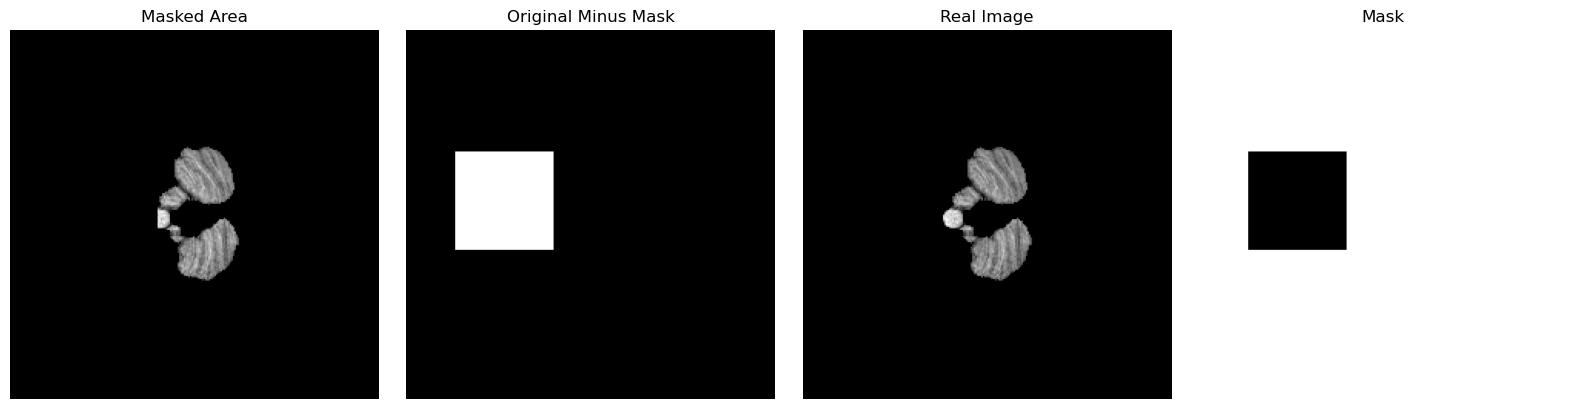

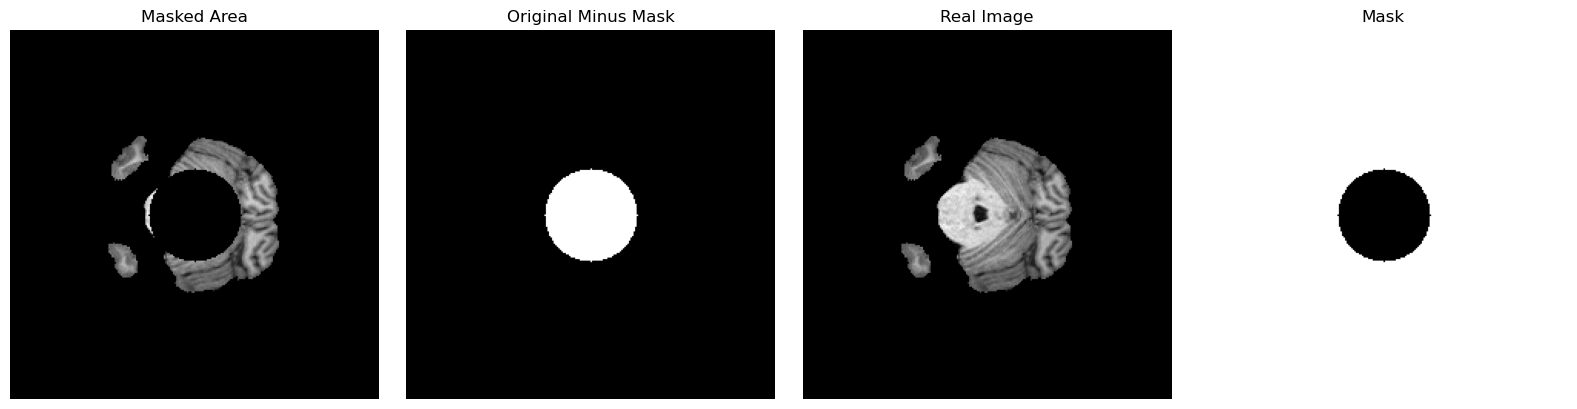

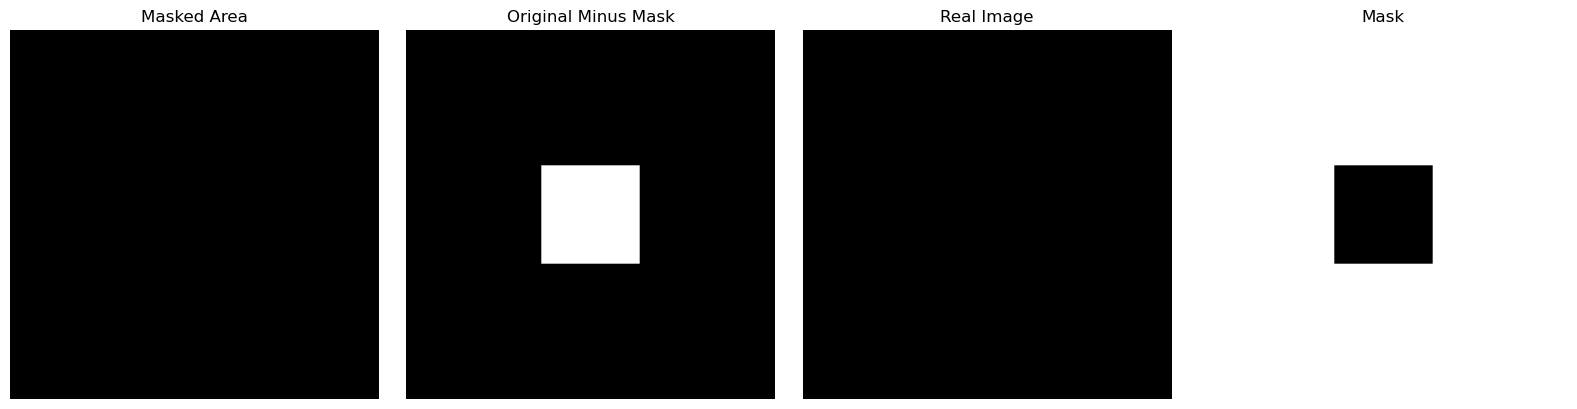

In [44]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import torch

# Helper function to visualize the data in the dataloader
def visualize_dataloader(dataloader, num_samples=5):
    """
    Visualizes a few samples from the dataloader.
    
    Args:
        dataloader: PyTorch DataLoader containing the dataset.
        num_samples: Number of samples to visualize.
    """
    for i, (generator_inputs, real_images, masks) in enumerate(dataloader):
        if i >= num_samples:
            break

        # Get the first sample in the batch
        gen_input = generator_inputs[0].cpu().numpy()
        real_image = real_images[0].cpu().numpy()
        mask = masks[0].cpu().numpy()

        # Extract the individual components for visualization
        mask_area = gen_input[0]  # First channel (masked area)
        original_minus_mask = gen_input[1]  # Second channel (original minus mask)

        # Plot the components
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        axes[0].imshow(mask_area, cmap="gray")
        axes[0].set_title("Masked Area")
        axes[0].axis("off")

        axes[1].imshow(original_minus_mask, cmap="gray")
        axes[1].set_title("Original Minus Mask")
        axes[1].axis("off")

        axes[2].imshow(real_image[0], cmap="gray")  # Real image (single channel)
        axes[2].set_title("Real Image")
        axes[2].axis("off")

        axes[3].imshow(mask[0], cmap="gray")  # Mask (single channel)
        axes[3].set_title("Mask")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()

# Visualize samples from the dataloader
visualize_dataloader(dataloader, num_samples=3)

In [45]:
# Training parameters
num_epochs = 30
checkpoint_dir = "./checkpoints"

# Ensure checkpoint directory exists
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

# Training Loop with Discriminator Update Scheduling
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    # Initialize a counter for generator updates
    generator_update_counter = 0

    for i, (generator_inputs, real_images, masks) in enumerate(dataloader):
        generator_inputs = generator_inputs.to(device)  # Shape: (B, 2, H, W)
        real_images = real_images.to(device)            # Shape: (B, 1, H, W)
        masks = masks.to(device)                        # Shape: (1, H, W)

        # =====================
        # Train Generator 5 Times
        # =====================
        for _ in range(5):
            optimizer_G.zero_grad()

            # Forward pass
            fake_images = generator(generator_inputs)

            # Adversarial loss
            fake_preds = discriminator(fake_images)
            real_targets = torch.ones_like(fake_preds, device=device)  # Labels for generator to fool discriminator
            g_adv_loss = adversarial_loss(fake_preds, real_targets)

            # L1 loss
            g_l1_loss = l1_loss(fake_images, real_images) * 100  # Adjust the weight as needed

            # Total generator loss
            g_loss = g_adv_loss + g_l1_loss

            # Backward pass and optimization
            g_loss.backward()
            optimizer_G.step()

            # Accumulate generator loss
            epoch_g_loss += g_loss.item()
            generator_update_counter += 1

        # =====================
        # Train Discriminator Once
        # =====================
        optimizer_D.zero_grad()

        # --------------------------------
        # (C) Train Discriminator once
        # --------------------------------
        optimizer_D.zero_grad()
        
        # 1) Real images in the hole region only
        real_images_masked = real_images * (1.0 - masks)
        real_preds = discriminator_update(real_images_masked)
        real_loss  = adversarial_loss(real_preds, torch.ones_like(real_preds, device=device))
        
        # 2) Fake images in the hole region only
        fake_images = generator_update(generator_update_input).detach()
        fake_images_masked = fake_images * (1.0 - masks)
        fake_preds = discriminator_update(fake_images_masked)
        fake_loss  = adversarial_loss(fake_preds, torch.zeros_like(fake_preds, device=device))
        
        # Combine
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()
        
        epoch_d_loss += d_loss.item()


        # Optional: Print losses every certain number of iterations
        if (i + 1) % 50 == 0 or (i + 1) == len(dataloader):
            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Calculate average losses for the epoch
    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / (len(dataloader) * 5)  # Since generator was updated 5 times per batch
    print(f"==> Epoch {epoch+1}/{num_epochs} Summary: [D loss: {avg_d_loss:.4f}] [G loss: {avg_g_loss:.4f}]")

    # Optionally save the model checkpoints
    if (epoch + 1) % 1 == 0:
        checkpoint_path = Path(checkpoint_dir)
        checkpoint_path.mkdir(parents=True, exist_ok=True)
        
        # Save generator
        if isinstance(generator, nn.DataParallel):
            torch.save(generator.module.state_dict(), checkpoint_path / f"generator_epoch_{epoch + 1}.pth")
        else:
            torch.save(generator.state_dict(), checkpoint_path / f"generator_epoch_{epoch + 1}.pth")
        
        # Save discriminator
        if isinstance(discriminator, nn.DataParallel):
            torch.save(discriminator.module.state_dict(), checkpoint_path / f"discriminator_epoch_{epoch + 1}.pth")
        else:
            torch.save(discriminator.state_dict(), checkpoint_path / f"discriminator_epoch_{epoch + 1}.pth")
        
        print(f"Saved checkpoints for epoch {epoch + 1} to {checkpoint_dir}")

print("Training finished.")

[Epoch 1/30] [Batch 50/480] [D loss: 0.2389] [G loss: 3099.6404]
[Epoch 1/30] [Batch 100/480] [D loss: 0.8805] [G loss: 1972.1012]
[Epoch 1/30] [Batch 150/480] [D loss: 0.0132] [G loss: 2806.0771]
[Epoch 1/30] [Batch 200/480] [D loss: 0.0092] [G loss: 2171.0540]
[Epoch 1/30] [Batch 250/480] [D loss: 0.0283] [G loss: 2900.4980]
[Epoch 1/30] [Batch 300/480] [D loss: 0.0076] [G loss: 2549.7212]
[Epoch 1/30] [Batch 350/480] [D loss: 0.0068] [G loss: 2088.7017]
[Epoch 1/30] [Batch 400/480] [D loss: 0.0054] [G loss: 2371.8628]
[Epoch 1/30] [Batch 450/480] [D loss: 0.6435] [G loss: 2379.9998]
[Epoch 1/30] [Batch 480/480] [D loss: 0.5467] [G loss: 2075.8059]
==> Epoch 1/30 Summary: [D loss: 0.2274] [G loss: 2380.1599]
Saved checkpoints for epoch 1 to ./checkpoints
[Epoch 2/30] [Batch 50/480] [D loss: 0.5531] [G loss: 2177.2319]
[Epoch 2/30] [Batch 100/480] [D loss: 0.4794] [G loss: 2512.5330]
[Epoch 2/30] [Batch 150/480] [D loss: 0.5579] [G loss: 1815.6368]
[Epoch 2/30] [Batch 200/480] [D loss

Segmentation mask shape: (240, 240, 155)
Converted segmentation mask to binary mask.
MRI image shape: (240, 240, 155)
Number of slices to process: 155
Processing slice 1/155...
Saved generated slice to ./experiment/img\generated_slice_001.nii
Processing slice 2/155...
Saved generated slice to ./experiment/img\generated_slice_002.nii
Processing slice 3/155...
Saved generated slice to ./experiment/img\generated_slice_003.nii
Processing slice 4/155...
Saved generated slice to ./experiment/img\generated_slice_004.nii
Processing slice 5/155...
Saved generated slice to ./experiment/img\generated_slice_005.nii
Processing slice 6/155...
Saved generated slice to ./experiment/img\generated_slice_006.nii
Processing slice 7/155...
Saved generated slice to ./experiment/img\generated_slice_007.nii
Processing slice 8/155...
Saved generated slice to ./experiment/img\generated_slice_008.nii
Processing slice 9/155...
Saved generated slice to ./experiment/img\generated_slice_009.nii
Processing slice 10/1

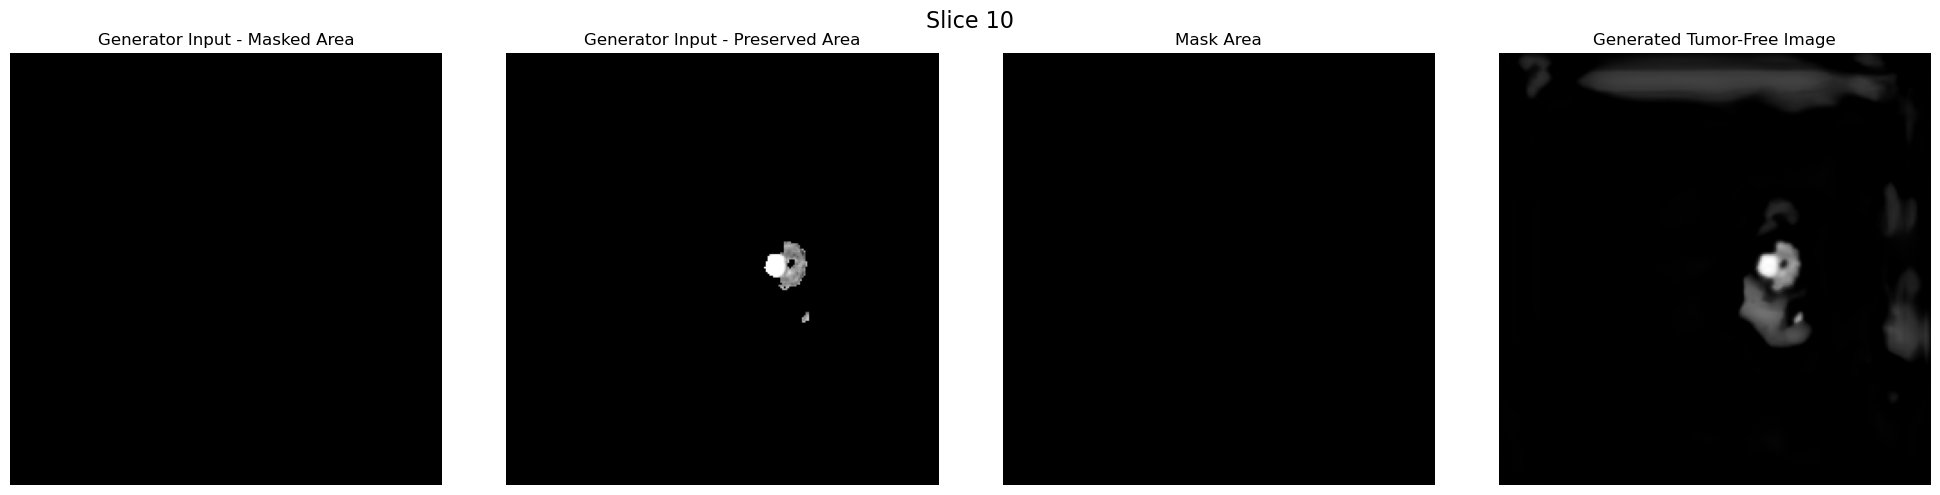

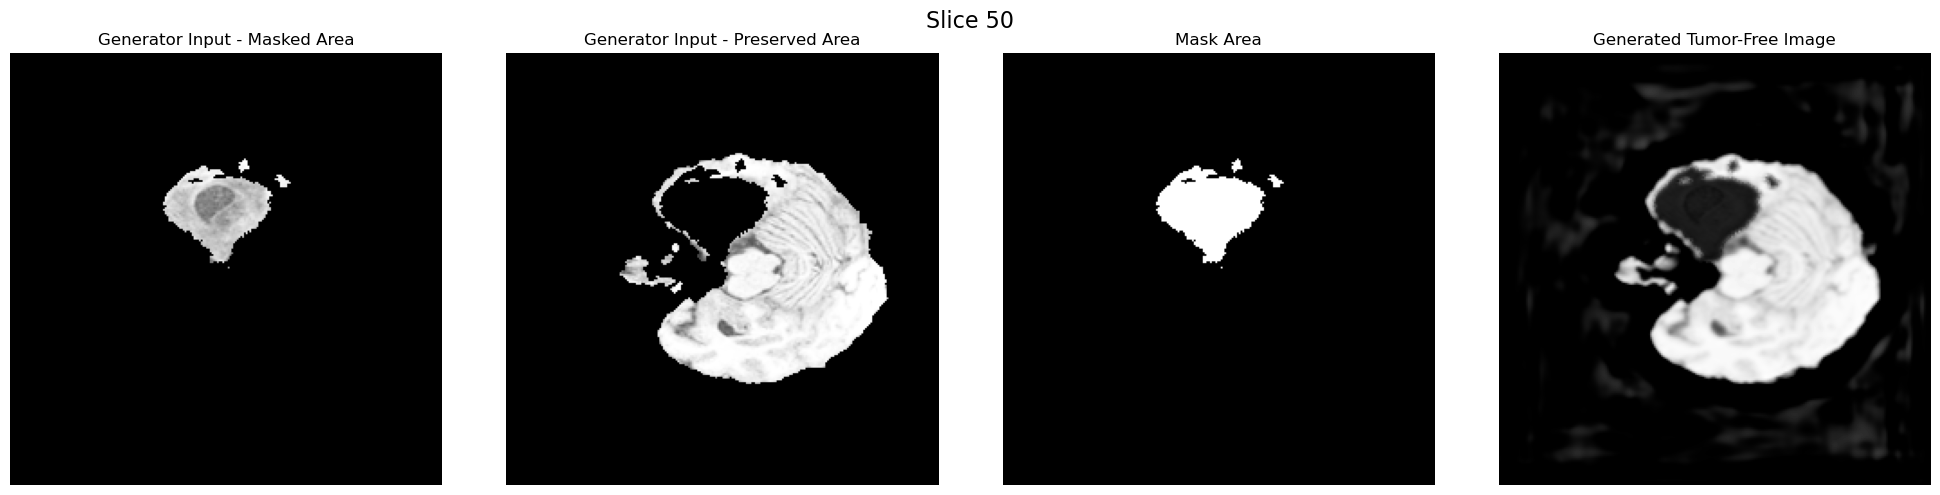

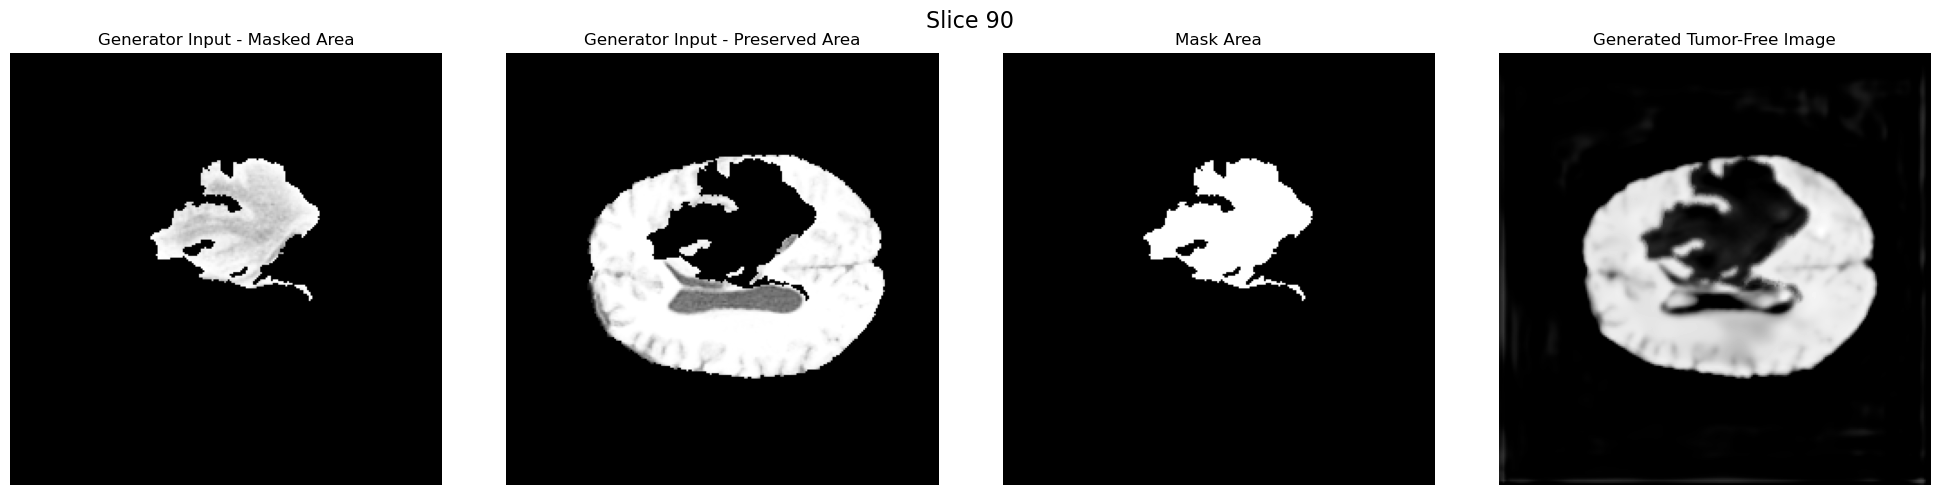

In [53]:
def visualize_results(generator_input, original, mask, generated, slice_idx, save_path=None):
    """
    Visualizes the generator input, original image, mask, and generated image side by side.

    Args:
        generator_input (numpy.ndarray): Generator input channels (masked area and preserved area).
        original (numpy.ndarray): Original MRI slice.
        mask (numpy.ndarray): Binary mask slice.
        generated (numpy.ndarray): Generated (tumor-free) image slice.
        slice_idx (int): Index of the slice being visualized.
        save_path (str, optional): Path to save the visualization image.
    """
    plt.figure(figsize=(20, 5))

    # Generator Input - Channel 1 (Masked Area)
    plt.subplot(1, 4, 1)
    plt.title("Generator Input - Masked Area")
    plt.imshow(generator_input[0], cmap='gray')
    plt.axis('off')

    # Generator Input - Channel 2 (Preserved Area)
    plt.subplot(1, 4, 2)
    plt.title("Generator Input - Preserved Area")
    plt.imshow(generator_input[1], cmap='gray')
    plt.axis('off')

    # Mask Area
    plt.subplot(1, 4, 3)
    plt.title("Mask Area")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    # Generated Image
    plt.subplot(1, 4, 4)
    plt.title("Generated Tumor-Free Image")
    plt.imshow(generated, cmap='gray')
    plt.axis('off')

    plt.suptitle(f"Slice {slice_idx + 1}", fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved visualization to {save_path}")
    else:
        plt.show()

def generate_tumor_free_image(seg_path, t1_path, output_dir, visualize_slices=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Generates tumor-free brain images by inpainting masked regions.

    Args:
        seg_path (str): Path to the segmentation mask NIfTI file.
        t1_path (str): Path to the T1 MRI NIfTI file.
        model_path (str): Path to the pretrained generator model.
        output_dir (str): Directory to save the generated images and visualizations.
        visualize_slices (list of int, optional): List of slice indices to visualize.
        device (str): Device to run the model on ('cuda' or 'cpu').
    """
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Load the segmentation mask
    seg_img = nib.load(seg_path)
    seg_data = seg_img.get_fdata()
    print(f"Segmentation mask shape: {seg_data.shape}")

    # Convert labels 1,2,4 to 1 (tumor regions)
    seg_binary = np.isin(seg_data, [1, 2, 4]).astype(np.float32)
    print("Converted segmentation mask to binary mask.")

    # Load the MRI image
    t1_img = nib.load(t1_path)
    t1_data = t1_img.get_fdata()
    print(f"MRI image shape: {t1_data.shape}")

    # Ensure that segmentation and MRI images have the same shape
    assert seg_data.shape == t1_data.shape, "Segmentation and MRI images must have the same shape."
    num_slices = seg_data.shape[2]
    print(f"Number of slices to process: {num_slices}")


    # Initialize lists to store visualization data
    visualization_data = []

    # Process each slice
    for slice_idx in range(num_slices):
        print(f"Processing slice {slice_idx + 1}/{num_slices}...")

        # Extract the slice from MRI and segmentation
        t1_slice = t1_data[:, :, slice_idx]
        seg_slice = seg_binary[:, :, slice_idx]

        # Apply image processing
        enhanced_slice = Img_proc(t1_slice)
        enhanced_slice = np.expand_dims(enhanced_slice, axis=0)  # Add channel dimension
        enhanced_slice_tensor = torch.tensor(enhanced_slice, dtype=torch.float32)

        # Convert to tensor and add batch dimension
        enhanced_slice_tensor = enhanced_slice_tensor.unsqueeze(0).to(device)  # Shape: (1, 1, H, W)

        # Create mask tensor
        mask = torch.tensor(seg_slice, dtype=torch.float32)
        mask = torch.unsqueeze(mask, 0)  # Shape: (1, H, W)
        mask = torch.unsqueeze(mask, 0).to(device)  # Shape: (1, 1, H, W)

        # Invert the mask: 1 -> tumor (mask out), 0 -> normal (keep)
        # Note: Ensure that this inversion aligns with how the mask was used during training
        inverted_mask = 1 - mask  # Shape: (1, 1, H, W)

        # Create mask_area and original_minus_mask
        mask_area = enhanced_slice_tensor * inverted_mask   # Shape: (1, 1, H, W) -> Tumor areas set to zero
        original_minus_mask = enhanced_slice_tensor * mask  # Shape: (1, 1, H, W) -> Normal areas preserved

        # Concatenate to form generator input
        generator_input = torch.cat([original_minus_mask, mask_area], dim=1)  # Shape: (1, 2, H, W)

        # Forward pass through the generator
        with torch.no_grad():
            fake_image = generator(generator_input)
            # Removed sigmoid activation as it's not used during training

        # Save the raw generator output
        fake_image_raw = fake_image.cpu().squeeze().numpy()
        nib.save(nib.Nifti1Image(fake_image_raw, affine=t1_img.affine),
                 os.path.join(output_dir, f"fake_image_raw_slice_{slice_idx + 1:03d}.nii"))

        # Post-process the generated image
        generated_np = fake_image_raw  # Assuming the output is already in [0,1]

        # Rotate back the original image and mask for visualization
        original_np = enhanced_slice_tensor.cpu().squeeze().numpy()
        mask_np = seg_slice  # Binary mask: 1 for tumor, 0 for normal

        # Create the final image by replacing the tumor areas with generated output
        final_image = (original_np) + (generated_np)
        #final_image = np.clip(final_image, 0, 1)

        # Save the final generated image as NIfTI
        generated_img = nib.Nifti1Image(final_image, affine=t1_img.affine)
        output_path = os.path.join(output_dir, f"generated_slice_{slice_idx + 1:03d}.nii")
        nib.save(generated_img, output_path)
        print(f"Saved generated slice to {output_path}")

        # Collect data for visualization if this slice is to be visualized
        if visualize_slices and slice_idx in visualize_slices:
            # Prepare generator input for visualization
            # generator_input has shape (1, 2, H, W)
            generator_input_np = generator_input.cpu().squeeze().numpy()

            visualization_data.append({
                'generator_input': generator_input_np,  # Shape: (2, H, W)
                'original': original_np,                 # Shape: (H, W)
                'mask': mask_np,                         # Shape: (H, W)
                'generated': generated_np,               # Shape: (H, W)
                'final_image': final_image,              # Shape: (H, W)
                'slice_idx': slice_idx
            })

    print("All slices processed and saved.")

    # Visualization
    if visualize_slices:
        for data in visualization_data:
            visualize_results(
                generator_input=data['generator_input'],
                original=data['original'],
                mask=data['mask'],
                generated=data['generated'],
                slice_idx=data['slice_idx'],
                save_path=os.path.join(output_dir, f"visualization_slice_{data['slice_idx'] + 1:03d}.png")
            )

    print("Visualization completed.")

# ---------------------------
# Execute the Inference and Visualization
# ---------------------------
if __name__ == "__main__":
    # Define paths
    seg_path = "./experiment/BraTS20_Training_001_seg.nii"
    t1_path = "./experiment/BraTS20_Training_001_t1.nii"

    # Specify slices to visualize (0-based indices)
    # For example, visualize slices 10, 50, and 90
    visualize_slices = [9, 49, 89]  # Adjust based on your data

    output_dir = './experiment/img'
    # Run the generation and visualization
    generate_tumor_free_image(seg_path, t1_path, output_dir, visualize_slices=visualize_slices)


In [74]:
generator_update = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)  # Input: 2 channels
discriminator_update = Discriminator(in_channels=1).to(device)  # Discriminator expects 1-channel images

# Training parameters
num_epochs = 30
checkpoint_dir = "./checkpoints"

# Ensure checkpoint directory exists
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

# Training Loop with Discriminator Update Scheduling
for epoch in range(num_epochs):
    generator_update.train()
    discriminator_update.train()

    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    for i, (generator_update_input, real_images, masks) in enumerate(dataloader):
        # Now you have all three explicitly
        real_images = real_images.to(device)
        masks       = masks.to(device)

        # --------------------------------
        # (A) Construct generator_update's input
        # --------------------------------
        
        # 1) The "masked" image: known region is real, the hole is zeroed out
        masked_image = real_images * masks  # shape: (B, 1, H, W)
        
        # 2) The binary mask channel (often the inverse for the hole)
        mask_channel = 1.0 - masks         # shape: (B, 1, H, W); 1.0 in the hole, 0.0 in the known area
        
        # 3) (Optional) Gaussian noise channel
        noise_std = 0.05  # adjust as needed
        noise_channel = torch.randn_like(real_images) * noise_std * masks # shape: (B, 1, H, W)
        
        # 4) Concatenate channels for generator_update
        #    Here we have 3 channels: masked_image, mask_channel, noise
        #    so the generator_update's first conv layer must expect in_channels=3
        generator_update_input = torch.cat([masked_image, mask_channel, noise_channel], dim=1)  # (B, 3, H, W)

        # ----------------------------------------------------------------
        # (B) Train generator_update multiple times before training Discriminator
        # ----------------------------------------------------------------
        for _ in range(5):
            optimizer_G.zero_grad()

            # Forward pass: produce a "completed" image
            fake_images = generator_update(generator_update_input)  # shape: (B, 1, H, W)

            # ------------------
            # generator_update Loss
            # ------------------
            # 1) Adversarial loss (GAN)
            fake_preds = discriminator_update(fake_images)
            g_adv_loss = adversarial_loss(fake_preds, torch.ones_like(fake_preds, device=device))
            
            # 2) L1 loss in the *masked region only*:
            #    This forces the generator_update to correctly reconstruct the hole
            l1_loss_masked = l1_loss(fake_images * (1.0 - masks), real_images * (1.0 - masks))
            g_l1_loss      = l1_loss_masked * 100.0   # Weighted, tune as necessary

            # Combined generator_update loss
            g_loss = g_adv_loss + g_l1_loss

            g_loss.backward()
            optimizer_G.step()

            epoch_g_loss += g_loss.item()

        # --------------------------------
        # (C) Train Discriminator once
        # --------------------------------
        # --------------------------------
        # (C) Train Discriminator once
        # --------------------------------
        optimizer_D.zero_grad()
        
        # 1) Real images in the hole region only
        real_images_masked = real_images * (1.0 - masks)
        real_preds = discriminator_update(real_images_masked)
        real_loss  = adversarial_loss(real_preds, torch.ones_like(real_preds, device=device))
        
        # 2) Fake images in the hole region only
        fake_images = generator_update(generator_update_input).detach()
        fake_images_masked = fake_images * (1.0 - masks)
        fake_preds = discriminator_update(fake_images_masked)
        fake_loss  = adversarial_loss(fake_preds, torch.zeros_like(fake_preds, device=device))
        
        # Combine
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        optimizer_D.step()
        
        epoch_d_loss += d_loss.item()
        

        # Print some info
        if (i + 1) % 50 == 0 or (i + 1) == len(dataloader):
            print(f"[Epoch {epoch+1}/{num_epochs}][Batch {i+1}/{len(dataloader)}] "
                  f"D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    # Average losses
    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / (len(dataloader) * 5)
    print(f"==> Epoch {epoch+1}/{num_epochs}: D_loss={avg_d_loss:.4f}, G_loss={avg_g_loss:.4f}")

    # Saving checkpoints, etc. (same as before)
    if (epoch + 1) % 1 == 0:
        checkpoint_path = Path(checkpoint_dir)
        checkpoint_path.mkdir(parents=True, exist_ok=True)
        
        # Save generator_update
        if isinstance(generator_update, nn.DataParallel):
            torch.save(generator_update.module.state_dict(), checkpoint_path / f"generator_update_epoch_{epoch + 1}.pth")
        else:
            torch.save(generator_update.state_dict(), checkpoint_path / f"generator_update_epoch_{epoch + 1}.pth")
        
        # Save discriminator_update
        if isinstance(discriminator_update, nn.DataParallel):
            torch.save(discriminator_update.module.state_dict(), checkpoint_path / f"discriminator_update_epoch_{epoch + 1}.pth")
        else:
            torch.save(discriminator_update.state_dict(), checkpoint_path / f"discriminator_update_epoch_{epoch + 1}.pth")
        
        print(f"Saved checkpoints for epoch {epoch + 1} to {checkpoint_dir}")

print("Training finished.")

[Epoch 1/30][Batch 50/480] D_loss: 0.7090 G_loss: 709.3066
[Epoch 1/30][Batch 100/480] D_loss: 0.7081 G_loss: 726.2347
[Epoch 1/30][Batch 150/480] D_loss: 0.7067 G_loss: 781.7690
[Epoch 1/30][Batch 200/480] D_loss: 0.7069 G_loss: 575.1824
[Epoch 1/30][Batch 250/480] D_loss: 0.7074 G_loss: 755.6130
[Epoch 1/30][Batch 300/480] D_loss: 0.7072 G_loss: 902.0214
[Epoch 1/30][Batch 350/480] D_loss: 0.7075 G_loss: 708.3167
[Epoch 1/30][Batch 400/480] D_loss: 0.7072 G_loss: 742.4293
[Epoch 1/30][Batch 450/480] D_loss: 0.7087 G_loss: 642.5699
[Epoch 1/30][Batch 480/480] D_loss: 0.7071 G_loss: 676.5773
==> Epoch 1/30: D_loss=0.7077, G_loss=737.9039
Saved checkpoints for epoch 1 to ./checkpoints
[Epoch 2/30][Batch 50/480] D_loss: 0.7083 G_loss: 816.1309
[Epoch 2/30][Batch 100/480] D_loss: 0.7066 G_loss: 782.0342
[Epoch 2/30][Batch 150/480] D_loss: 0.7064 G_loss: 714.6357
[Epoch 2/30][Batch 200/480] D_loss: 0.7079 G_loss: 772.2078
[Epoch 2/30][Batch 250/480] D_loss: 0.7084 G_loss: 663.3275
[Epoch 2

KeyboardInterrupt: 

Segmentation mask shape: (240, 240, 155)
Converted segmentation mask to binary mask.
MRI image shape: (240, 240, 155)
Number of slices to process: 155
Processing slice 1/155...
Saved generated slice to ./experiment/img\generated_slice_001.nii
Processing slice 2/155...
Saved generated slice to ./experiment/img\generated_slice_002.nii
Processing slice 3/155...
Saved generated slice to ./experiment/img\generated_slice_003.nii
Processing slice 4/155...
Saved generated slice to ./experiment/img\generated_slice_004.nii
Processing slice 5/155...
Saved generated slice to ./experiment/img\generated_slice_005.nii
Processing slice 6/155...
Saved generated slice to ./experiment/img\generated_slice_006.nii
Processing slice 7/155...
Saved generated slice to ./experiment/img\generated_slice_007.nii
Processing slice 8/155...
Saved generated slice to ./experiment/img\generated_slice_008.nii
Processing slice 9/155...
Saved generated slice to ./experiment/img\generated_slice_009.nii
Processing slice 10/1

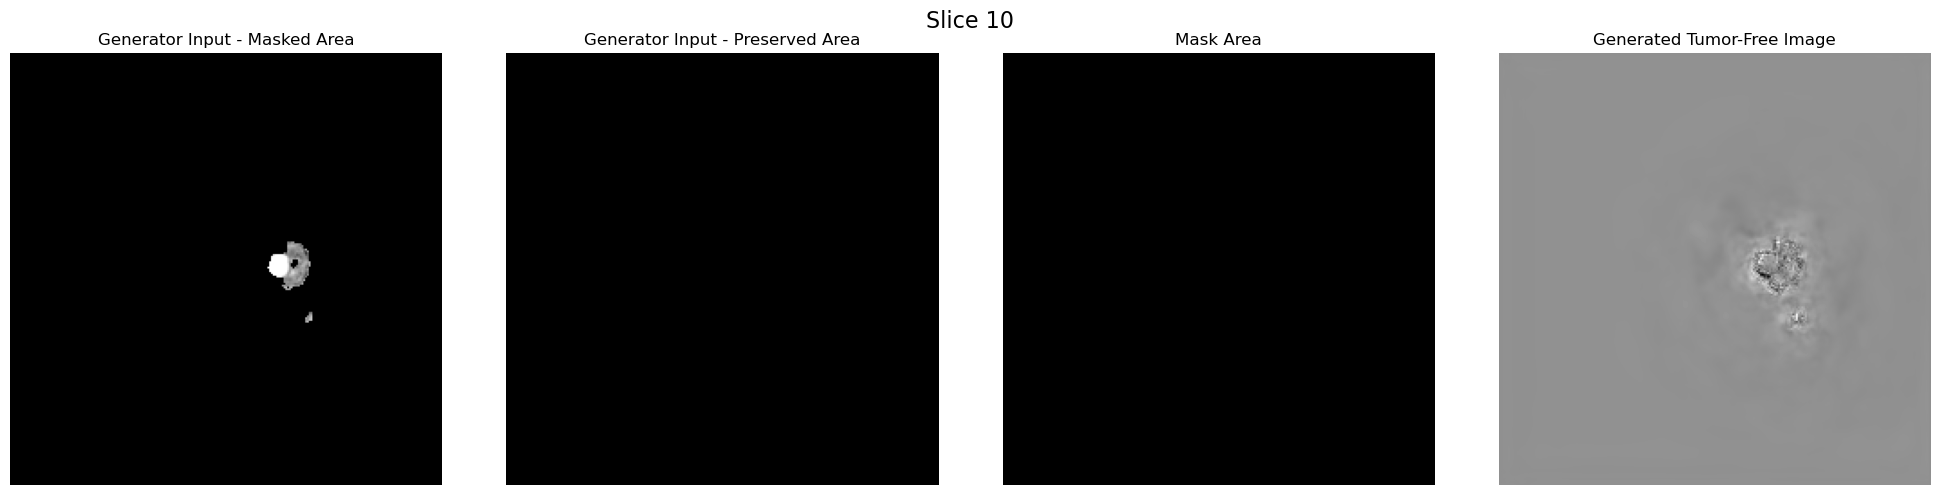

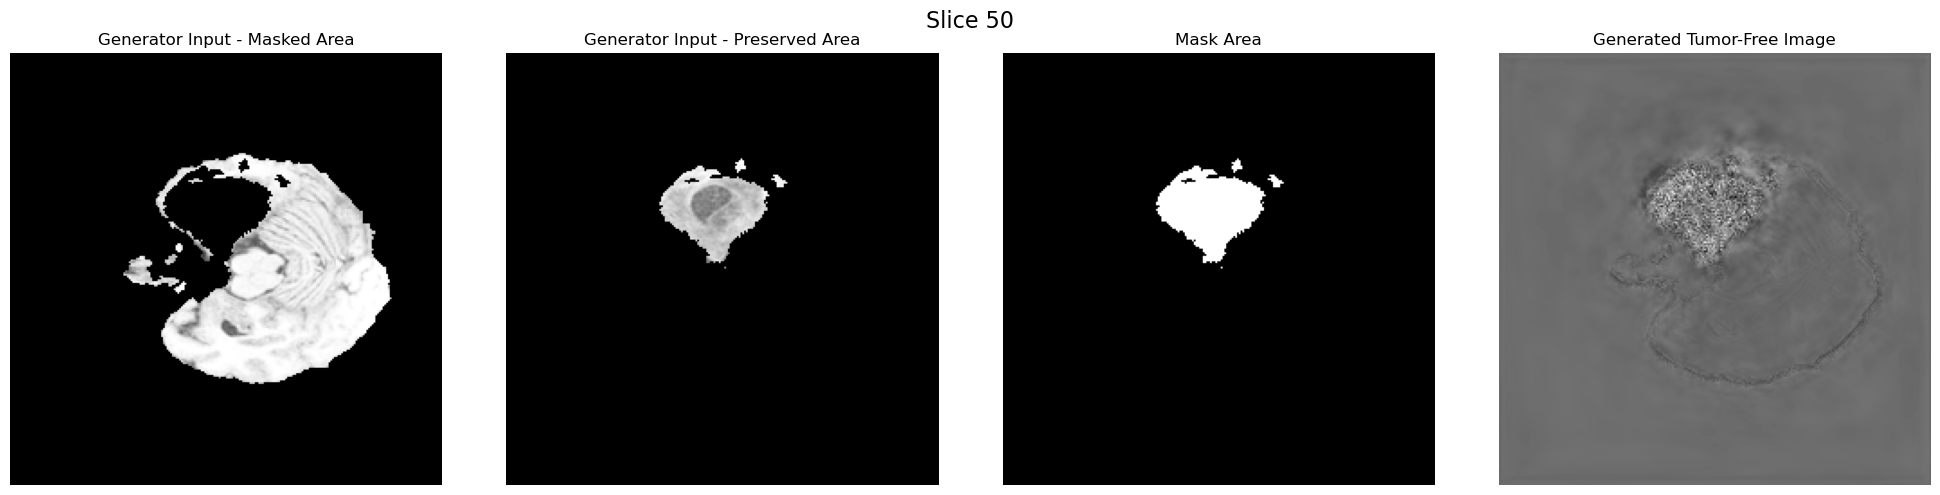

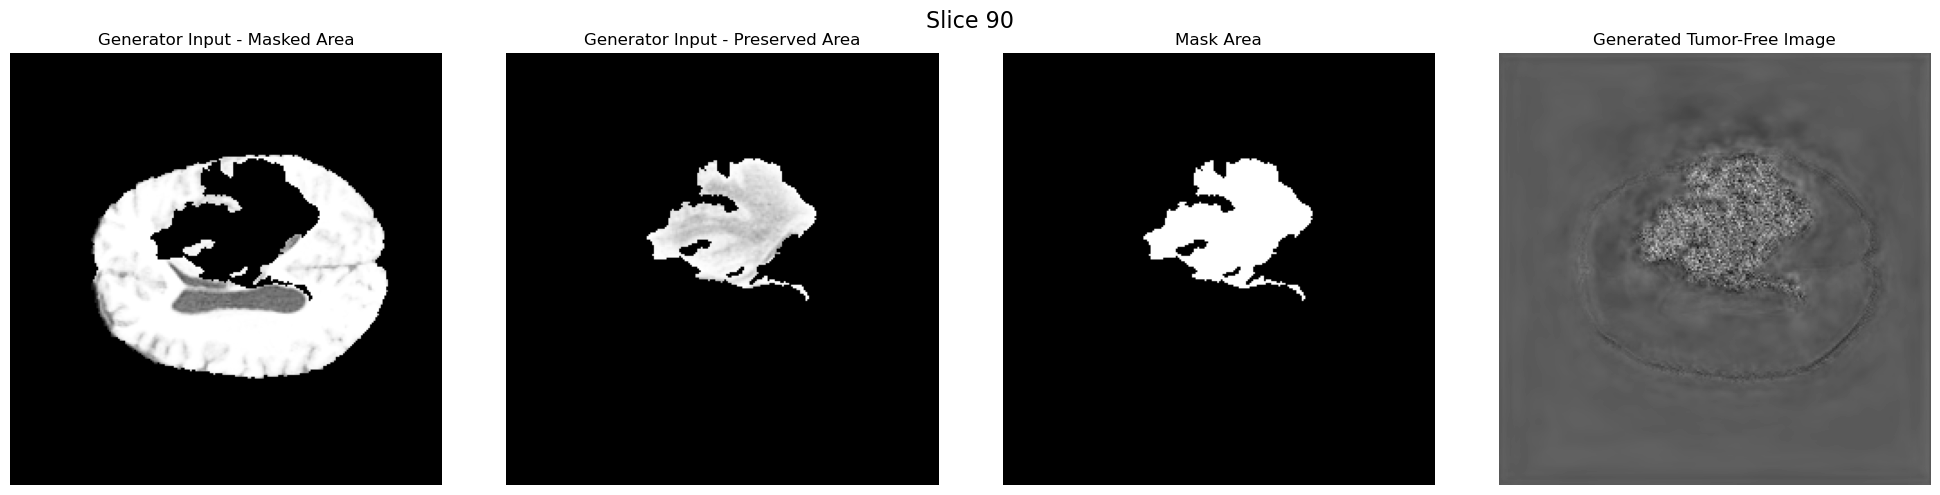

In [72]:
generator = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)


def visualize_results(generator_input, original, mask, generated, slice_idx, save_path=None):
    """
    Visualizes the generator input, original image, mask, and generated image side by side.

    Args:
        generator_input (numpy.ndarray): Generator input channels (masked area and preserved area).
        original (numpy.ndarray): Original MRI slice.
        mask (numpy.ndarray): Binary mask slice.
        generated (numpy.ndarray): Generated (tumor-free) image slice.
        slice_idx (int): Index of the slice being visualized.
        save_path (str, optional): Path to save the visualization image.
    """
    plt.figure(figsize=(20, 5))

    # Generator Input - Channel 1 (Masked Area)
    plt.subplot(1, 4, 1)
    plt.title("Generator Input - Masked Area")
    plt.imshow(generator_input[0], cmap='gray')
    plt.axis('off')

    # Generator Input - Channel 2 (Preserved Area)
    plt.subplot(1, 4, 2)
    plt.title("Generator Input - Preserved Area")
    plt.imshow(generator_input[1], cmap='gray')
    plt.axis('off')

    # Mask Area
    plt.subplot(1, 4, 3)
    plt.title("Mask Area")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    # Generated Image
    plt.subplot(1, 4, 4)
    plt.title("Generated Tumor-Free Image")
    plt.imshow(generated, cmap='gray')
    plt.axis('off')

    plt.suptitle(f"Slice {slice_idx + 1}", fontsize=16)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved visualization to {save_path}")
    else:
        plt.show()

def generate_tumor_free_image(
    seg_path,
    t1_path,
    output_dir,
    visualize_slices=None,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    """
    Generates tumor-free brain images by inpainting masked regions, now with a noise channel.

    Args:
        seg_path (str): Path to the segmentation mask NIfTI file.
        t1_path (str): Path to the T1 MRI NIfTI file.
        output_dir (str): Directory to save the generated images and visualizations.
        visualize_slices (list of int, optional): List of slice indices to visualize.
        device (str): Device to run the model on ('cuda' or 'cpu').
    """
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Load the segmentation mask
    seg_img = nib.load(seg_path)
    seg_data = seg_img.get_fdata()
    print(f"Segmentation mask shape: {seg_data.shape}")

    # Convert labels 1,2,4 to 1 (tumor regions)
    seg_binary = np.isin(seg_data, [1, 2, 4]).astype(np.float32)
    print("Converted segmentation mask to binary mask.")

    # Load the MRI image
    t1_img = nib.load(t1_path)
    t1_data = t1_img.get_fdata()
    print(f"MRI image shape: {t1_data.shape}")

    # Ensure that segmentation and MRI images have the same shape
    assert seg_data.shape == t1_data.shape, "Segmentation and MRI images must have the same shape."
    num_slices = seg_data.shape[2]
    print(f"Number of slices to process: {num_slices}")

    # Initialize lists to store visualization data
    visualization_data = []

    # Process each slice
    for slice_idx in range(num_slices):
        print(f"Processing slice {slice_idx + 1}/{num_slices}...")

        # Extract the slice from MRI and segmentation
        t1_slice = t1_data[:, :, slice_idx]
        seg_slice = seg_binary[:, :, slice_idx]

        # Apply image processing (e.g., your custom Img_proc)
        enhanced_slice = Img_proc(t1_slice)  # shape (H, W) after processing
        # Add channel dimension => (1, H, W)
        enhanced_slice = np.expand_dims(enhanced_slice, axis=0)
        # Convert to tensor => (1, 1, H, W)
        enhanced_slice_tensor = torch.tensor(enhanced_slice, dtype=torch.float32).unsqueeze(0).to(device)

        # Create mask tensor => (1, 1, H, W)
        mask = torch.tensor(seg_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Invert the mask to get "tumor region = 0, normal region = 1"
        inverted_mask = 1 - mask

        # original_minus_mask: keep normal region
        original_minus_mask = enhanced_slice_tensor * inverted_mask
        # mask_area: keep tumor region (zero-out normal region)
        mask_area = enhanced_slice_tensor * mask

        # ---------------------------
        # ADD A NOISE CHANNEL
        # ---------------------------
        # The shape of original_minus_mask or mask_area is (1, 1, H, W).
        # We'll create a noise channel with the same shape (1, 1, H, W).
        noise_channel = torch.randn_like(original_minus_mask) * mask

        # Concatenate to form generator input => (1, 3, H, W)
        # Channel 0: original_minus_mask
        # Channel 1: mask_area
        # Channel 2: noise
        generator_input = torch.cat([original_minus_mask, mask_area, noise_channel], dim=1)
        noise_channel = noise_channel.cpu().squeeze().numpy()

        # Forward pass through the generator
        with torch.no_grad():
            fake_image = generator(generator_input)
            # Typically you might apply activation if your generator outputs logits, 
            # but if you trained w/o an activation, skip it here.

        # Save the raw generator output
        fake_image_raw = fake_image.cpu().squeeze().numpy()
        nib.save(nib.Nifti1Image(fake_image_raw, affine=t1_img.affine),
                 os.path.join(output_dir, f"fake_image_raw_slice_{slice_idx + 1:03d}.nii"))

        # Post-process the generated image as needed
        generated_np = fake_image_raw  # shape (H, W)

        # For final image creation, you might combine original and fake in some way:
        original_np = enhanced_slice_tensor.cpu().squeeze().numpy()  # shape (H, W)
        mask_np = seg_slice  # shape (H, W)
        final_image = (original_np) + (generated_np)

        # Save the final generated image as NIfTI
        generated_img = nib.Nifti1Image(final_image, affine=t1_img.affine)
        output_path = os.path.join(output_dir, f"generated_slice_{slice_idx + 1:03d}.nii")
        nib.save(generated_img, output_path)
        print(f"Saved generated slice to {output_path}")

        # Collect data for visualization if requested
        if visualize_slices and slice_idx in visualize_slices:
            # We have (1, 3, H, W) => remove batch dimension => (3, H, W)
            generator_input_np = generator_input.cpu().squeeze(0).numpy()

            visualization_data.append({
                'generator_input': generator_input_np,   # shape: (3, H, W)
                'original': original_np,                 # shape: (H, W)
                'mask': mask_np,                         # shape: (H, W)
                'generated': generated_np,               # shape: (H, W)
                'final_image': final_image,              # shape: (H, W)
                'slice_idx': slice_idx,
                'noise_channel': noise_channel
            })

    print("All slices processed and saved.")

    # Visualization
    if visualize_slices:
        for data in visualization_data:
            visualize_results(
                generator_input=data['generator_input'],
                original=data['original'],
                mask=data['mask'],
                generated=data['generated'],
                slice_idx=data['slice_idx'],
                save_path=os.path.join(output_dir, f"visualization_slice_{data['slice_idx'] + 1:03d}.png")
            )

    print("Visualization completed.")


# ---------------------------
# Execute the Inference and Visualization
# ---------------------------
if __name__ == "__main__":
    # Define paths
    seg_path = "./experiment/BraTS20_Training_001_seg.nii"
    t1_path = "./experiment/BraTS20_Training_001_t1.nii"

    # Specify slices to visualize (0-based indices)
    # For example, visualize slices 10, 50, and 90
    visualize_slices = [9, 49, 89]  # Adjust based on your data

    output_dir = './experiment/img'
    # Run the generation and visualization
    generate_tumor_free_image(seg_path, t1_path, output_dir, visualize_slices=visualize_slices)
